# DeepDream

440742/440742 [==============================] - 0s 0us/step


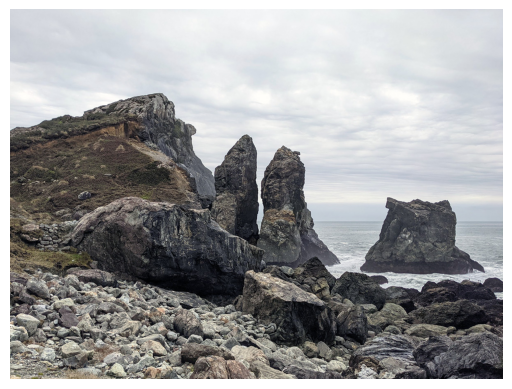

In [1]:
import matplotlib.pyplot as plt
from tensorflow import keras

base_image_path = keras.utils.get_file(
    "coast.jpg", origin="https://img-datasets.s3.amazonaws.com/coast.jpg"
)

plt.axis("off")
plt.imshow(keras.utils.load_img(base_image_path))

## Instantiating a pretrained `InceptionV3` model

In [2]:
from tensorflow.keras.applications import inception_v3

model = inception_v3.InceptionV3(weights="imagenet", include_top=False)

Metal device set to: Apple M1 Max


2023-02-18 21:10:59.546117: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-18 21:10:59.546299: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


87910968/87910968 [==============================] - 2s 0us/step


In [3]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                    

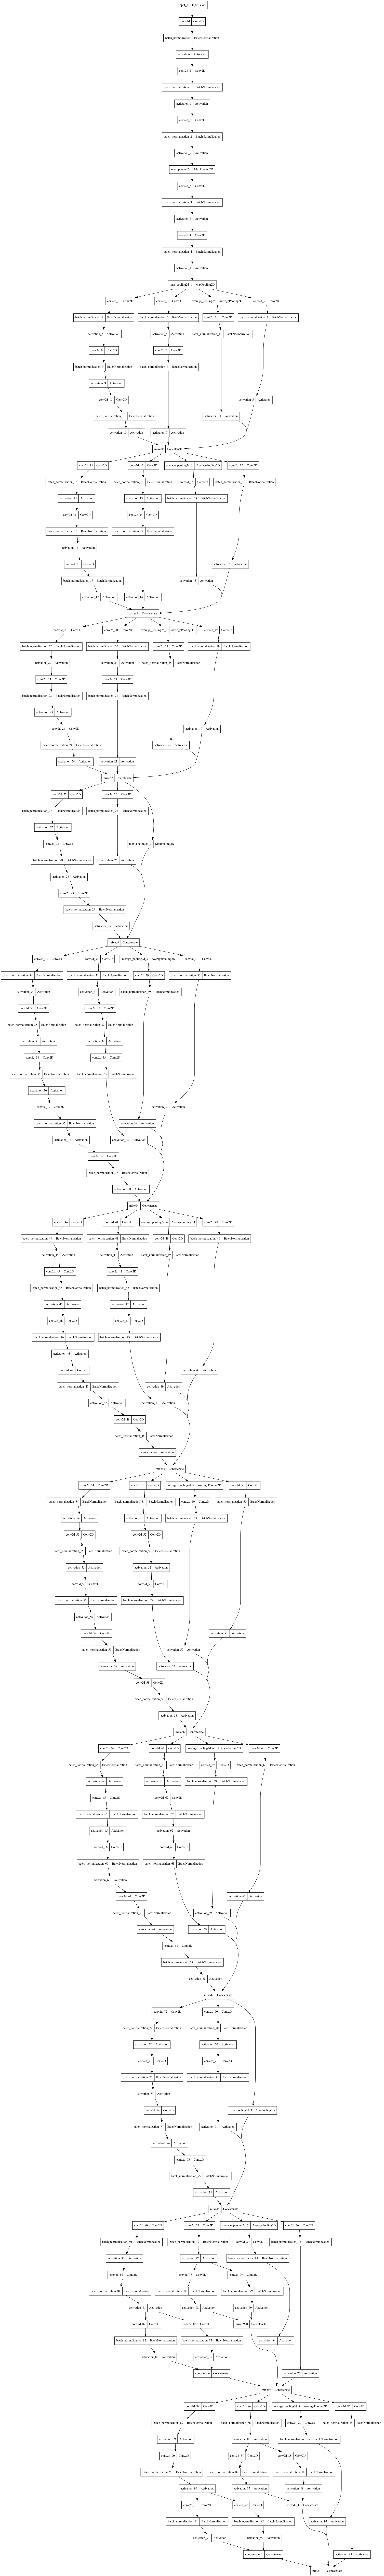

In [4]:
keras.utils.plot_model(model, "./assets/inception_v3.png", show_shapes=False)

## The DeepDream loss

In [5]:
layer_settings = {
    "mixed4": 1.0,
    "mixed5": 1.5,
    "mixed6": 2.0,
    "mixed7": 2.5,
}
outputs_dict = dict(
    [
        (layer.name, layer.output)
        for layer in [model.get_layer(name) for name in layer_settings.keys()]
    ]
)
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

## The DeepDream gradient ascent process

In [6]:
def compute_loss(input_image):
    features = feature_extractor(input_image)
    loss = tf.zeros(shape=())
    for name in features.keys():
        coeff = layer_settings[name]
        activation = features[name]
        loss += coeff * tf.reduce_mean(tf.square(activation[:, 2:-2, 2:-2, :]))
    return loss

In [7]:
import tensorflow as tf


@tf.function
def gradient_ascent_step(image, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    return loss, image


def gradient_ascent_loop(image, iterations, learning_rate, max_loss=None):
    for i in range(iterations):
        loss, image = gradient_ascent_step(image, learning_rate)
        if max_loss is not None and loss > max_loss:
            break
        print(f"... Loss value at step {i}: {loss:.2f}")
    return image

In [8]:
step = 20.0
num_octave = 3
octave_scale = 1.4
iterations = 30
max_loss = 15.0

## Image processing utilities

In [9]:
import numpy as np


def preprocess_image(image_path):
    img = keras.utils.load_img(image_path)
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.inception_v3.preprocess_input(img)
    return img


def deprocess_image(img):
    img = img.reshape((img.shape[1], img.shape[2], 3))
    img /= 2.0
    img += 0.5
    img *= 255.0
    img = np.clip(img, 0, 255).astype("uint8")
    return img

## Running gradient ascent over multiple successive "octaves"

In [10]:
original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]

successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale**i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]

shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

img = tf.identity(original_img)
for i, shape in enumerate(successive_shapes):
    print(f"Processing octave {i} with shape {shape}")
    img = tf.image.resize(img, shape)
    img = gradient_ascent_loop(
        img, iterations=iterations, learning_rate=step, max_loss=max_loss
    )
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
    same_size_original = tf.image.resize(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img
    img += lost_detail
    shrunk_original_img = tf.image.resize(original_img, shape)

out_put_file_path = "./assets/dream.png"
keras.utils.save_img(out_put_file_path, deprocess_image(img.numpy()))

Processing octave 0 with shape (459, 612)


2023-02-18 21:14:56.267409: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-18 21:14:56.274907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


... Loss value at step 0: 0.80
... Loss value at step 1: 1.07
... Loss value at step 2: 1.44
... Loss value at step 3: 1.82
... Loss value at step 4: 2.15
... Loss value at step 5: 2.47
... Loss value at step 6: 2.84
... Loss value at step 7: 3.18
... Loss value at step 8: 3.52
... Loss value at step 9: 3.88
... Loss value at step 10: 4.21
... Loss value at step 11: 4.62
... Loss value at step 12: 4.97
... Loss value at step 13: 5.33
... Loss value at step 14: 5.66
... Loss value at step 15: 6.04
... Loss value at step 16: 6.34
... Loss value at step 17: 6.73
... Loss value at step 18: 7.03
... Loss value at step 19: 7.40
... Loss value at step 20: 7.70
... Loss value at step 21: 8.05
... Loss value at step 22: 8.31
... Loss value at step 23: 8.65
... Loss value at step 24: 8.91
... Loss value at step 25: 9.20
... Loss value at step 26: 9.49
... Loss value at step 27: 9.84
... Loss value at step 28: 10.08
... Loss value at step 29: 10.32
Processing octave 1 with shape (642, 857)


2023-02-18 21:15:00.985174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


... Loss value at step 0: 1.56
... Loss value at step 1: 2.57
... Loss value at step 2: 3.35
... Loss value at step 3: 3.95
... Loss value at step 4: 4.49
... Loss value at step 5: 5.00
... Loss value at step 6: 5.50
... Loss value at step 7: 5.91
... Loss value at step 8: 6.38
... Loss value at step 9: 6.81
... Loss value at step 10: 7.20
... Loss value at step 11: 7.54
... Loss value at step 12: 7.98
... Loss value at step 13: 8.17
... Loss value at step 14: 8.60
... Loss value at step 15: 8.72
... Loss value at step 16: 9.18
... Loss value at step 17: 9.40
... Loss value at step 18: 9.79
... Loss value at step 19: 10.02
... Loss value at step 20: 10.62
... Loss value at step 21: 10.67
... Loss value at step 22: 11.23
... Loss value at step 23: 11.30
... Loss value at step 24: 11.93
... Loss value at step 25: 11.93
... Loss value at step 26: 12.53
... Loss value at step 27: 12.83
... Loss value at step 28: 13.28
... Loss value at step 29: 13.53
Processing octave 2 with shape (900, 12

2023-02-18 21:15:03.945608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


... Loss value at step 0: 1.40
... Loss value at step 1: 2.16
... Loss value at step 2: 2.79
... Loss value at step 3: 3.29
... Loss value at step 4: 3.77
... Loss value at step 5: 4.23
... Loss value at step 6: 4.69
... Loss value at step 7: 5.12
... Loss value at step 8: 5.56
... Loss value at step 9: 6.04
... Loss value at step 10: 6.33
... Loss value at step 11: 6.73
... Loss value at step 12: 6.99
... Loss value at step 13: 7.63
... Loss value at step 14: 7.87
... Loss value at step 15: 8.44
... Loss value at step 16: 8.68
... Loss value at step 17: 9.30
... Loss value at step 18: 9.45
... Loss value at step 19: 10.10
... Loss value at step 20: 10.27
... Loss value at step 21: 10.75
... Loss value at step 22: 11.02
... Loss value at step 23: 11.64
... Loss value at step 24: 11.98
... Loss value at step 25: 12.43
... Loss value at step 26: 12.88
... Loss value at step 27: 13.17
... Loss value at step 28: 13.69
... Loss value at step 29: 14.05


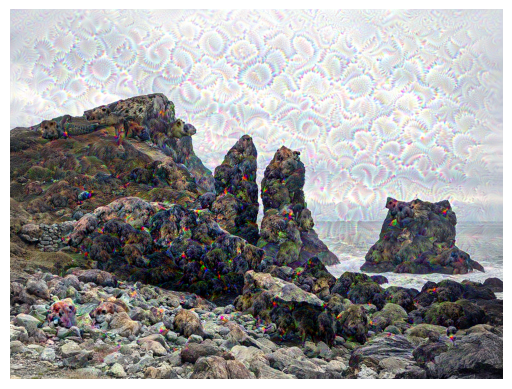

In [12]:
plt.axis("off")
plt.imshow(keras.utils.load_img(out_put_file_path))